## Extending Smooth Transitioning Exponential Smoothing Volatility Forecasts

This notebook corresponds to the blog series [Extending Smooth Transitioning Exponential Smoothing Volatility Forecasts](https://steveya.github.io/2024/07/12/volatility-forecast-1.html). The aim is to replace the logistic function used by the STES model with a xgboost model, and evaluate their relative performance. It is a work in progress and will be updated as I wrap up my implementations.

In [1]:
import numpy as np
import pandas as pd
from functools import partial
from scipy.optimize import minimize, least_squares
from scipy.special import expit
from matplotlib import pyplot as plt
from operator import itemgetter
import yfinance as yf
import xgboost as xgb
import random

### Replicating the Results Presented in [Part 1](https://steveya.github.io/2024/07/12/volatility-forecast-1.html) of the Volatility Forecasting Series

The code in this section will reproduce Table 1 and Table 2of the blog post, which implements the Smooth Transition Exponential Smoothing (STES) model in [(Taylor, 2004)](https://doi.org/10.1016/j.ijforecast.2003.09.010) and further analyzed in [(Liu, Taylor, Choo 2020)](https://doi.org/10.1016/j.econmod.2020.02.021)

The `simulated_contaminated_garch` function implements the simulation used in Liu et al. The rest of this section implements STES on different feature sets and follows the convention used in (Taylor 2004).

In [2]:
def simulate_contaminated_garch(n, mu, omega, alpha, beta, eta):
    returns = np.zeros(n)
    sigma2s = np.zeros(n)
    shocks = (np.random.uniform(0, 1, n) < 0.005).astype(float)
    for t in range(1, n):
        sigma2s[t] = omega + alpha * returns[t-1]**2 + beta * sigma2s[t-1]
        returns[t] = np.random.normal(mu, np.sqrt(sigma2s[t])) + eta * shocks[t]

    return returns, sigma2s

In [3]:
def stes_template(params, returns, features_func):
    """
    This function generates the variance forecasts and the 
    alphas for each time step using the STES model.

    Parameters
    ----------
    params : numpy.ndarray
        The parameters of the STES model.
    returns : numpy.ndarray
        The returns of the time series.
    features_func : list
        A list of functions that extract features from the returns.

    Returns
    -------
    sigma2s : numpy.ndarray
        The variance forecasts.
    alphas : numpy.ndarray
        The alphas for each time step.
    """
    assert len(params) == len(features_func)
    n = len(returns)
    sigma2s = np.zeros(n)
    alphas = np.zeros(n)
    for t in range(1, n):
        features = np.array([f(returns[t-1]) for f in features_func])
        alpha = expit(params @ features)
        alphas[t-1] = alpha
        sigma2s[t] = (1 - alphas[t-1]) * sigma2s[t-1] + alphas[t-1] * returns[t-1]**2

    return sigma2s, alphas


In [4]:
# feature functions used in the `feature_func` argument of `stes_template``
const = lambda _: 1
abs_x = np.abs
sqr_x = lambda x: x**2
id_x = lambda x: x

We use the above `stes_template` function to define the set of STES models used in (Taylor, 2004).

In [308]:
# building all the STES models (with ES being a special case)
es = partial(stes_template, features_func=(const,)) 
stes_ae = partial(stes_template, features_func=(const, abs_x))
stes_se = partial(stes_template, features_func=(const, sqr_x))
stes_eae = partial(stes_template, features_func=(const, abs_x, id_x))
stes_ese = partial(stes_template, features_func=(const, sqr_x, id_x))
stes_aese = partial(stes_template, features_func=(const, abs_x, sqr_x))
stes_eaese = partial(stes_template, features_func=(const, id_x, abs_x, sqr_x))

We also define loss of each observation as the squared of the forecasting error. We also define two metrics that help us compute root mean squared error (`rmse_metric`) and negative log-likelihood (`nllh_metric`).

In [6]:
def squared_residual(params, model, returns, is_index=500, os_index=2000):
    sigma2s, _ = model(params, returns)
    sse = (returns ** 2 - sigma2s)
    residual = sse[is_index:os_index]
    return residual

def rmse_metric(model, params, returns, is_index=500, os_index=2000):
    sigma2s, alphas = model(params, returns)
    
    sse = (returns ** 2 - sigma2s) ** 2
    is_rmse = np.sqrt(np.mean(sse[is_index:os_index]))
    os_rmse = np.sqrt(np.mean(sse[os_index:]))
    return is_rmse, os_rmse, sigma2s, alphas

def nllh_metric(model, params, returns, is_index=500, os_index=2000):
    sigma2s, alphas = model(params, returns)
   
    llh = -np.log(sigma2s[2:]) - (returns[2:] ** 2 / sigma2s[2:])
    is_nllh = -np.sum(llh[is_index:os_index])
    os_nllh = -np.sum(llh[os_index:])
    return is_nllh, os_nllh, sigma2s, alphas

I tested two ways to optimize the parameters of the general stes model. The first is to directly compute the root mean squared error (RMSE) from `rmse_metric` function, take the first output `is_rmse`, and use  `scipy.optimize.minimize` to find the optimal parameters. The second is to compute the residuals from `squared_residual` and then use `scipy.optimize.least_squares` to find the optimal parameters. I initialize the initial parameters to the optimizer using random draws from a standard gaussian distribution. 

I found that the second method is more robust to parameters initialization. Below are the expeiment fitting the `stes_ae` model using the two approaches with 10 random initialization.

In [309]:
def fit_model_minimize(model, param_dim, returns, is_index=500, os_index=2000):
    initial_params = np.random.normal(0, 1, size=param_dim)
    obj_func_inner = lambda *args, **kwargs: itemgetter(0)(partial(rmse_metric, model)(*args, **kwargs))
    result = minimize(obj_func_inner, initial_params, args=(returns, is_index, os_index), method = 'SLSQP')
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    is_mse, os_mse, sigmas, alphas = rmse_metric(model,result.x, returns, is_index, os_index)
    is_llh, os_llh, _, _ = nllh_metric(model, result.x, returns, is_index, os_index)
    return (result.x, os_mse, os_llh, sigmas, alphas, is_mse, is_llh)

def fit_model_least_square(model, param_dim, returns, is_index=500, os_index=2000):
    initial_params = np.random.normal(0, 1, size=param_dim)
    obj_func_inner = partial(squared_residual, model=model, returns=returns, is_index=is_index, os_index=os_index)
    result = least_squares(obj_func_inner, initial_params)
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    is_mse, os_mse, sigmas, alphas = rmse_metric(model,result.x, returns, is_index, os_index)
    is_llh, os_llh, _, _ = nllh_metric(model, result.x, returns, is_index, os_index)
    return (result.x, os_mse, os_llh, sigmas, alphas, is_mse, is_llh)

fit_es_minimize = partial(fit_model_minimize, model=es, param_dim=1)
fit_stes_ae_minimize = partial(fit_model_minimize, model=stes_ae, param_dim=2)
fit_stes_se_minimize = partial(fit_model_minimize, model=stes_se, param_dim=2)
fit_stes_eae_minimize = partial(fit_model_minimize, model=stes_eae, param_dim=3)
fit_stes_ese_minimize = partial(fit_model_minimize, model=stes_ese, param_dim=3)
fit_stes_aese_minimize = partial(fit_model_minimize, model=stes_aese, param_dim=3)

fit_es_least_square = partial(fit_model_least_square, model=es, param_dim=1)
fit_stes_ae_least_square = partial(fit_model_least_square, model=stes_ae, param_dim=2)
fit_stes_se_least_square = partial(fit_model_least_square, model=stes_se, param_dim=2)
fit_stes_ese_least_square = partial(fit_model_least_square, model=stes_ese, param_dim=3)
fit_stes_eae_least_square = partial(fit_model_least_square, model=stes_eae, param_dim=3)
fit_stes_aese_least_square = partial(fit_model_least_square, model=stes_aese, param_dim=3)
fit_stes_eaese_least_square = partial(fit_model_least_square, model=stes_eaese, param_dim=4)



To demonstrate that the `least_squares` optimizer works better in this case, we fit the same STES model with the same random initialization to a fixed return time series, and assess the stability of the fitted parameters.

In [10]:
np.random.seed(0)
np.random.seed(np.random.randint(0, 1e4, size=1))
simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(
    n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4
)

In [11]:
np.random.seed(0)
for _ in range(10):
    lss = least_squares(
        partial(
            squared_residual, 
            model=stes_ae, 
            returns=simulated_garch_return
        ), x0=np.random.normal(0, 1, 2)) 
    print(lss.x)

[-2.1670995  -0.11246057]
[-2.16702008 -0.11246866]
[-2.16714041 -0.11245641]
[-2.16711731 -0.11245876]
[-2.16701855 -0.11246882]
[-2.16712513 -0.11245797]
[-2.16697288 -0.11247378]
[-2.16716552 -0.11245386]
[-2.16707807 -0.11246275]
[-2.16712244 -0.11245824]


In [12]:
np.random.seed(0)
for _ in range(10):
    p, _, _, _, _, _, _ = fit_stes_ae_minimize(
        returns=simulated_garch_return
    )
    print(p)

[-2.16674593 -0.11249054]
[-11.80986301 -16.08684575]
[-2.1676799  -0.11233752]
[-2.1670345  -0.11249873]
[-2.16680262 -0.11192826]
[-2.16696151 -0.11245809]
[-2.1671567  -0.11248048]
[-2.16675334 -0.11247579]
[-2.16611258 -0.11210408]
[-2.16630593 -0.11304955]


Given exact same simualted sequence and random seeds used to gnerate the initial values to the optimizer, the `fit_stest_ae_minimize` function unstable optimas. After some playing around, the `fit_stest_ae_leastsquares` function seems to converge to a stable solution in repeated random runs.

Perhaps the `fit_stest_ae_minimize` function can (and should) be further tuned, but the `fit_stest_ae_leastsquares` function seems to converge to a stable solution in repeated random runs without any tuning.

#### STES and ES Performance on Simulated Contaminated GARCH Data
I simulate the contaminated GARCH time series using the same parameters as in the Taylor (2020) paper. I then fit the STES and ES models to the simulated data and measure their performance on the test sample 1-step ahead root mean square forecast error. The results are shown in Table 1.

In [111]:
stes_ae_os_rmses = []
stes_se_os_rmses = []
es_os_rmses = []

num_runs = 1000
np.random.seed(0)
rand_seeds = np.random.randint(0, 1e6, size=num_runs)
for i in range(num_runs):
    np.random.seed(rand_seeds[i])
    simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4)
    _, os_stes_se_rmse, _, _, _, _, _ = fit_stes_se_least_square(returns=simulated_garch_return)
    _, os_stes_ae_rmse, _, _, _, _, _ = fit_stes_ae_least_square(returns=simulated_garch_return)
    _,      os_es_rmse,      _, _, _, _, _ = fit_es_least_square(returns=simulated_garch_return)
    stes_ae_os_rmses.append(os_stes_ae_rmse)
    stes_se_os_rmses.append(os_stes_se_rmse)
    es_os_rmses.append(os_es_rmse)


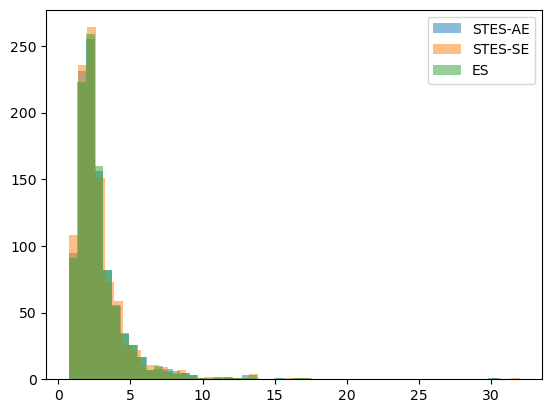

The mean of RMSE of the STES-AE model is 2.8452412258472464
The mean of RMSE of the STES-SE model is 2.8787248873818627
The mean of RMSE of the ES model is 2.85216396301645


In [112]:
plt.hist(stes_ae_os_rmses, bins=50, alpha=0.5, label='STES-AE')
plt.hist(stes_se_os_rmses, bins=50, alpha=0.5, label='STES-SE')
plt.hist(es_os_rmses, bins=50, alpha=0.5, label='ES')

plt.legend()
plt.show()

print(f"The mean of RMSE of the STES-AE model is {np.mean(stes_ae_os_rmses)}")
print(f"The mean of RMSE of the STES-SE model is {np.mean(stes_se_os_rmses)}")
print(f"The mean of RMSE of the ES model is {np.mean(es_os_rmses)}")


#### STES and ES on SPY Data
I take the data from 2000 and fit the first 4000 data points (this part deviate from Taylor (2020), where they fit to data up to 2010.) Our test-sample starts from 2015-11-27.

The RMSE reported is the average RMST of 100 different random initialization.

In [ ]:
spy_adj_close = yf.download("SPY", start="2000-01-01", end="2023-12-31")
spy_log_returns = np.log(spy_adj_close["Adj Close"]).diff().dropna() * 100

[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(f"SPY daily returns series has length {len(spy_log_returns)}")
print(f"Test data starts from {spy_log_returns.index[4000]}")

SPY daily returns series has length 6036
Test data starts from 2015-11-27 00:00:00


In [313]:
np.random.seed(0)
stes_eaese_spy_res = [fit_stes_eaese_least_square(returns=spy_log_returns.to_numpy(), is_index=200, os_index=4000) for _ in range(100)]

In [314]:
np.random.seed(0)
stes_aese_spy_res = [fit_stes_aese_least_square(returns=spy_log_returns.to_numpy(), is_index=200, os_index=4000) for _ in range(100)]

In [ ]:
np.random.seed(0)
stes_eae_spy_res = [fit_stes_eae_least_square(returns=spy_log_returns.to_numpy(), is_index=200, os_index=4000) for _ in range(100)]

In [ ]:
np.random.seed(0)
stes_ese_spy_res = [fit_stes_ese_least_square(returns=spy_log_returns.to_numpy(), is_index=200, os_index=4000) for _ in range(100)]

In [ ]:
np.random.seed(0)
es_spy_res = [fit_es_least_square(returns=spy_log_returns.to_numpy(), is_index=200, os_index=4000) for _ in range(100)]

In [315]:
print(f"""
      STES E&AE&SE Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in stes_eaese_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in stes_eaese_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in stes_eaese_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in stes_eaese_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in stes_eaese_spy_res]):.6f},
""")


      STES E&AE&SE Parameter Estimated on SPY Returns using MLE: [-2.13971751 -0.1875335   0.19358432 -0.04260397],  
      Out-of-Sample Mean Squared Error = 4.482820, 
      Out-of-Sample Neg Log-Likelihood = 1675.407590, 
      In-Sample Mean Squared Error = 4.982193,
      In-Sample Neg Log-Likelihood = 3810.830719,



In [ ]:
print(f"""
      STES AE&SE Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in stes_aese_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in stes_aese_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in stes_aese_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in stes_aese_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in stes_aese_spy_res]):.6f},
""")


      STES AE&SE Parameter Estimated on SPY Returns using MLE: [-1.99369875  0.14583494 -0.01878969],  
      Out-of-Sample Mean Squared Error = 4.489537, 
      Out-of-Sample Neg Log-Likelihood = 1694.970797, 
      In-Sample Mean Squared Error = 5.015911,
      In-Sample Neg Log-Likelihood = 3881.140969,



In [ ]:
print(f"""
      STES E&AE Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in stes_eae_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in stes_eae_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in stes_eae_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in stes_eae_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in stes_eae_spy_res]):.6f},
""")


      STES E&AE Parameter Estimated on SPY Returns using MLE: [-1.74420506 -0.0881549  -0.07851254],  
      Out-of-Sample Mean Squared Error = 4.518936, 
      Out-of-Sample Neg Log-Likelihood = 1758.061537, 
      In-Sample Mean Squared Error = 5.010678,
      In-Sample Neg Log-Likelihood = 3967.358026,



In [ ]:
print(f"""
      STES E&SE Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in stes_ese_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in stes_ese_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in stes_ese_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in stes_ese_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in stes_ese_spy_res]):.6f},
""")


      STES E&SE Parameter Estimated on SPY Returns using MLE: [-1.9648798  -0.03371338 -0.28462538],  
      Out-of-Sample Mean Squared Error = 4.495169, 
      Out-of-Sample Neg Log-Likelihood = 1715.324391, 
      In-Sample Mean Squared Error = 4.987671,
      In-Sample Neg Log-Likelihood = 3849.004265,



In [ ]:
print(f"""
      ES Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in es_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in es_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in es_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in es_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in es_spy_res]):.6f},
""")


      ES Parameter Estimated on SPY Returns using MLE: [-2.18338667],  
      Out-of-Sample Mean Squared Error = 4.637673, 
      Out-of-Sample Neg Log-Likelihood = 1696.482945, 
      In-Sample Mean Squared Error = 5.056481,
      In-Sample Neg Log-Likelihood = 3854.738697,



### XGBoost-Based Exponential Smoothing Model, Code and Results in [Part 2](https://steveya.github.io/2024/07/12/volatility-forecast-2.html) of the Volatility Forecasting Series

#### XGBoost-STES Implementation

In [210]:
from sklearn.base import BaseEstimator, RegressorMixin

In [296]:
class XGBoostExponentialSmoothing(BaseEstimator, RegressorMixin):
    def __init__(self, **xgb_params):
        self.xgb_params = xgb_params
        self.model = None
        
    def stes_variance_objective(self, preds, dtrain):
        labels = dtrain.get_label()
        alphas = expit(preds)
        
        returns2 = self.data['returns^2'].to_numpy()
        
        grads = np.zeros_like(preds)
        hesss = np.zeros_like(preds)
        varhs = np.zeros_like(preds)

        assert len(preds) == len(labels), "Mismatch between lengths of preds, returns, and labels"

        for t in range(len(alphas)):
            if t == 0:
                lvar_f = np.mean(returns2[:500])
                varhs[t] = alphas[t] * returns2[t] + (1 - alphas[t]) * lvar_f
                d_alpha = returns2[t] - lvar_f
            else:
                varhs[t] = alphas[t] * returns2[t] + (1 - alphas[t]) * varhs[t-1]
                d_alpha = returns2[t] - varhs[t-1]
            
            d_pred = -alphas[t] * (1 - alphas[t]) * d_alpha
            grads[t] = 2 * (labels[t] - varhs[t]) * d_pred
            hesss[t] = 2 * d_pred**2

        return grads, hesss

    def fit(self, X, y):
        assert 'returns^2' in X, "returns^2 must be in the features!"
        
        self.data = X.copy()
        dtrain = xgb.DMatrix(X, label=y)
        
        self.model = xgb.train(
            self.xgb_params, dtrain, 
            obj=self.stes_variance_objective, 
            evals=[(dtrain, 'train')], verbose_eval=False
        )

        if self.model is None:
            raise RuntimeError("Model training failed and no model was created.")
        
        return self.model

    def predict(self, X):
        assert 'returns^2' in X, "returns^2 must be in the features!"

        if self.model is None:
            raise RuntimeError("You must train the model before predicting data!")
        
        if "label" in X:
            dtest = xgb.DMatrix(X.drop('label', axis=1))
        else:
            dtest = xgb.DMatrix(X)

        preds = self.model.predict(dtest)
        
        return preds

    def forecast_variance(self, X, burnin_size):
        """
        This function generates predictions for the 1-step ahead variance
        from the features time series. Since the variance is recursively 
        computed, X should be the full sample of features. Once computed,
        one can take the slice of indices of interest (val_index for example)
        to compute the metrics.

        Args:
            X (pd.DataFrame): The features time series.
            burnin_size (int): The number of samples to use to initialize
            the variance.

        Returns:
            np.ndarray: The 1-step ahead variance predictions.
        """
        assert 'returns^2' in X, "returns^2 must be in the features!"

        alphas = expit(self.predict(X))
        
        returns2 = X['returns^2'].to_numpy()
        var_pred = np.zeros_like(alphas)
        var_pred[:burnin_size] = np.mean(returns2[:burnin_size])
        
        for t in range(burnin_size, len(returns2)):
            var_pred[t] = alphas[t] * returns2[t] + (1 - alphas[t]) * var_pred[t-1]
        
        return var_pred

    # Scikit-learn interface
    def get_params(self, deep=True):
        """
        Return the parameters of the estimator.
        """
        return self.xgb_params

    def set_params(self, **params):
        for key, value in params.items():
            self.xgb_params[key] = value

        return self


In [297]:
xgb_params = {
    'num_boost_round': 10,     # Number of boosting iterations
    'max_depth': 3,            # Maximum depth of the tree
    'learning_rate': 0.1,      # Learning rate
    'colsample_bytree': 0.8,   # Column subsampling at tree level
    'colsample_bylevel': 0.8,  # Column subsampling at level level
    'colsample_bynode': 0.8,   # Column subsampling at node level
    'reg_lambda': 1.0,         # L2 regularization
    'random_state': 42,        # Seed for reproducibility
}

#### XGBoost-STES and ES Performance on Simulated Contaminated GARCH Data
Again, we test how XGBoost-Based Exponential Smoothing Model (untuned) perform against the simple ES model on simulated contaminated GARCH data. Previously, I did not find STES outperforming ES on this data, and I actually do not expect either STES or XGBoost to outperform ES, given that the groudtruth is a constant parameter GARCH with some added outliers.

In [298]:
import warnings
warnings.simplefilter("error")

In [299]:
xgb_stes_is_rmses = []
es_is_rmses = []

xgb_stes_os_rmses = []
es_os_rmses = []

num_runs = 1000
np.random.seed(0)
rand_seeds = np.random.randint(0, 1e6, size=num_runs)
for i in range(num_runs):
    np.random.seed(rand_seeds[i])
    
    simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(
        n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4
    )
    simulated_garch_feature_matrix = pd.DataFrame.from_dict({
        'returns': simulated_garch_return[:-1],
        'abs(returns)': np.abs(simulated_garch_return[:-1]),
        'returns^2': simulated_garch_return[:-1]**2,
        'label': simulated_garch_return[1:]**2,
    })
    
    xgb_params_iter = xgb_params.copy()
    xgb_stes_model = XGBoostExponentialSmoothing(**xgb_params_iter)
    xgb_stes_model.fit(
        simulated_garch_feature_matrix.iloc[500:2000, :-1], 
        simulated_garch_feature_matrix.iloc[500:2000, -1]
    )

    xgb_stes_predicted_garch_var_fs = xgb_stes_model.forecast_variance(
        simulated_garch_feature_matrix.iloc[:, :-1], burnin_size=500
    )
    is_xgb_stes_rmse = np.sqrt(
        np.mean((
            xgb_stes_predicted_garch_var_fs[500:2000] - 
            simulated_garch_feature_matrix.iloc[500:2000, -1]
        )**2)
    )
    os_xgb_stes_rmse = np.sqrt(
        np.mean((
            xgb_stes_predicted_garch_var_fs[-500:] - 
            simulated_garch_feature_matrix.iloc[-500:, -1]
        )**2)
    )

    _, os_es_rmse, _, _, _, is_es_rmse, _ = fit_es_least_square(
        returns=simulated_garch_return
    )

    xgb_stes_is_rmses.append(is_xgb_stes_rmse)
    es_is_rmses.append(is_es_rmse)

    xgb_stes_os_rmses.append(os_xgb_stes_rmse)
    es_os_rmses.append(os_es_rmse)


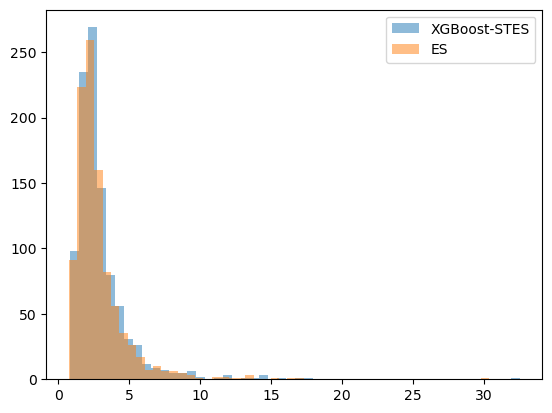

Average RMSE of the XGBoost-STES model on the test set is 2.9953074686499144
Average RMSE of the ES model on the test set is 2.8521640302629376


In [302]:
plt.hist(xgb_stes_os_rmses, bins=50, alpha=0.5, label='XGBoost-STES')
plt.hist(es_os_rmses, bins=50, alpha=0.5, label='ES')

plt.legend()
plt.show()

print(f"Average RMSE of the XGBoost-STES model on the test set is {np.mean(xgb_stes_os_rmses)}")
print(f"Average RMSE of the ES model on the test set is {np.mean(es_os_rmses)}")


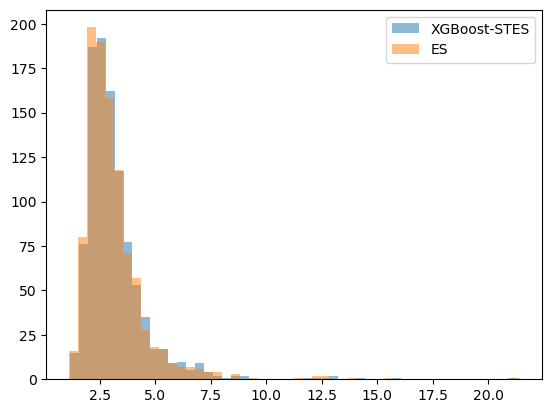

Average RMSE of the XGBoost-STES model on the train set is 3.1892718469428547
Average RMSE of the ES model on the train setis 3.12996515517658


In [303]:
plt.hist(xgb_stes_is_rmses, bins=50, alpha=0.5, label='XGBoost-STES')
plt.hist(es_is_rmses, bins=50, alpha=0.5, label='ES')

plt.legend()
plt.show()

print(f"Average RMSE of the XGBoost-STES model on the train set is {np.mean(xgb_stes_is_rmses)}")
print(f"Average RMSE of the ES model on the train setis {np.mean(es_is_rmses)}")


On the simulated data, without tuning, the XGBoostExponentialSmoothing model has a higher RMSE than the exponential smoothing model. This actually does not surprise me, as the ground truth is primarily driven by a GARCH(1,1) model with constant parameters, which the constant ES model is better at capturing.

#### XGBoost-STES and ES Performance on SPY Data
Now we test the XGBoost-STES model on SPY variance forecasts versus the ES model. Previously, we did not tune the XGBoost-STES model on the simulated GARCH data. For this analysis on real market data, I test both the tuned and untuned version of the XGBoost-STES model. The results are shown in Table 2. Train sample: 2000-01-01 - 2015-11-26, Test sample: 2015-11-27 - 2023-12-31.

In [194]:
spy_feature_matrix = pd.DataFrame.from_dict({
    'returns': spy_log_returns.to_numpy()[:-1],
    'abs(returns)': np.abs(spy_log_returns.to_numpy()[:-1]),
    'returns^2': spy_log_returns.to_numpy()[:-1]**2,
    'label': spy_log_returns.to_numpy()[1:]**2,
})

In [195]:
X_train = spy_feature_matrix.iloc[:4000, :-1]
y_train = spy_feature_matrix.iloc[:4000:, -1] 
X_test = spy_feature_matrix.iloc[4000:, :-1]
y_test = spy_feature_matrix.iloc[4000:, -1]


##### Out-of-the-Box XGBoost-STES Forecast on SPY Realized Variance
Fit and calculate the RMSE of an Untuned XGBoost-based exponential smoothing model on SPY returns.

In [ ]:
xgb_stes_spy_model_untuned = XGBoostExponentialSmoothing(
    **xgb_params)
xgb_stes_spy_model_untuned.fit(X_train, y_train)
xgb_stes_spy_model_untuned_pred = xgb_stes_spy_model_untuned.forecast_variance(
    spy_feature_matrix, burnin_size=10
)
os_xgb_stes_spy_untuned_rmse = np.sqrt(
    np.mean(
        (xgb_stes_spy_model_untuned_pred[4000:] - y_test.to_numpy())**2
    )
)
is_xgb_stes_spy_untuned_rmse = np.sqrt(
    np.mean(
        (xgb_stes_spy_model_untuned_pred[10:4000] - y_train.to_numpy()[10:])**2
    )
)
print('XGBoost-STES SPY Untuned RMSE:', os_xgb_stes_spy_untuned_rmse)
print(is_xgb_stes_spy_untuned_rmse, os_xgb_stes_spy_untuned_rmse)

5.01551322667555 4.4194610714382145


##### XGBoost-STES (Tuned using RandomizedSearchCV) Forecast on SPY Realized Variance

In [209]:

def xgb_stes_scoring_function(y_true, y_pred, starting_index=0):
    """
    Calculates the RMSE of the predicted variance against 
    the true 1-day realized variance. The prediction from 
    the XGBoost model needs to go through sigmoid first 
    to be transformed into alpha, which is then used to 
    recursively compute the 1-day ahead variance forecast.

    Arguments
    ---------
    y_true : numpy.ndarray
        The squared returns of the return time series.
    y_pred : numpy.ndarray
        The predicted values from XGBoost.

    Returns
    -------
    mse : float
        The mean squared error between the true and predicted variance.
    """
    alphas = expit(y_pred)
    var_pred = np.zeros_like(alphas)
    y_true_np = y_true.to_numpy()
    # y_true is 1-day squared returns.
    var_pred[0] = y_true_np[0]  

    for t in range(1, len(y_true)):
        var_pred[t] = alphas[t] * y_true_np[t-1] + (1 - alphas[t]) * var_pred[t-1]

    mse = np.mean((y_true_np - var_pred)[starting_index:] ** 2)
    return -mse  # Negate the MSE because GridSearchCV maximizes the score


In [211]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform, loguniform

In [213]:

def random_cv_tune_xgboost_model(X, y):
    param_dist = {
        'num_boost_round': [1, 5, 10, 20, 50, 100],
        'max_depth': randint(1, 5),
        'learning_rate': loguniform(0.01, 10),
        #'ts_subsample': uniform(0.3, 0.3),
        'reg_lambda': loguniform(0.1, 10.0),
        'colsample_bytree': uniform(0.1, 0.6),
        'colsample_bylevel': uniform(0.1, 0.6),
        'colsample_bynode': uniform(0.1, 0.6),
    }
    
    # Initialize the model
    model = XGBoostExponentialSmoothing()
    
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Use RandomizedSearchCV to find the best parameters
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        scoring=make_scorer(xgb_stes_scoring_function),
        cv=tscv,
        n_iter=80,
        verbose=1,
        random_state=42,
        error_score='raise',
    )

    random_search.fit(X, y)
    
    return random_search

In [214]:
# Perform hyperparameter tuning
xgb_stes_spy_tuner_rcv = random_cv_tune_xgboost_model(X_train, y_train)
xgb_stes_spy_best_params_rcv = xgb_stes_spy_tuner_rcv.best_params_

print("Best Parameters:", xgb_stes_spy_best_params_rcv)


Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best Parameters: {'colsample_bylevel': 0.3591670111852695, 'colsample_bynode': 0.27473748411882515, 'colsample_bytree': 0.46711173683342766, 'learning_rate': 0.02621087878265441, 'max_depth': 4, 'num_boost_round': 20, 'reg_lambda': 0.5404103854647329}


In [215]:
pd.DataFrame(xgb_stes_spy_tuner_rcv.cv_results_)[['params','mean_test_score']].sort_values('mean_test_score', ascending=False)

,params,mean_test_score
28,"{'colsample_bylevel': 0.2955753431211309, 'col...",-30.111501
49,"{'colsample_bylevel': 0.3468123430340071, 'col...",-30.111501
67,"{'colsample_bylevel': 0.6703642881625336, 'col...",-30.111501
20,"{'colsample_bylevel': 0.3137787028461849, 'col...",-30.111501
61,"{'colsample_bylevel': 0.331237972579339, 'cols...",-30.111501
...,...,...
24,"{'colsample_bylevel': 0.260068608565171, 'cols...",-35.582677
62,"{'colsample_bylevel': 0.30900196267191843, 'co...",-35.582677
44,"{'colsample_bylevel': 0.35186851386776585, 'co...",-35.582677
60,"{'colsample_bylevel': 0.14161678052509927, 'co...",-35.582677


In [216]:
xgb_params_rcv_tuned = xgb_params | xgb_stes_spy_best_params_rcv  #xgb_params | xgb_stes_spy_best_params
xgb_params_rcv_tuned

{'max_depth': 4,
 'learning_rate': 0.02621087878265441,
 'colsample_bytree': 0.46711173683342766,
 'colsample_bylevel': 0.3591670111852695,
 'colsample_bynode': 0.27473748411882515,
 'reg_lambda': 0.5404103854647329,
 'random_state': 42,
 'num_boost_round': 20}

In [217]:
xgb_stes_spy_model_tuned = XGBoostExponentialSmoothing(**xgb_params_rcv_tuned)
xgb_stes_spy_model_tuned.fit(X_train, y_train)
xgb_stes_spy_model_tuned_pred = xgb_stes_spy_model_tuned.forecast_variance(
    spy_feature_matrix, burnin_size=10
)
os_xgb_stes_spy_tuned_rmse = np.sqrt(np.mean((xgb_stes_spy_model_tuned_pred[4000:] - y_test.to_numpy())**2))
os_xgb_stes_spy_tuned_rmse

is_xgb_stes_spy_tuned_rmse = np.sqrt(np.mean((xgb_stes_spy_model_tuned_pred[10:4000] - y_train.to_numpy()[10:])**2))
os_xgb_stes_spy_tuned_rmse, is_xgb_stes_spy_tuned_rmse


(4.428388206980347, 5.201166237381078)

Let's plot the alpha time series.

Text(0.5, 1.0, 'XGBoost-STES Tuned Alpha')

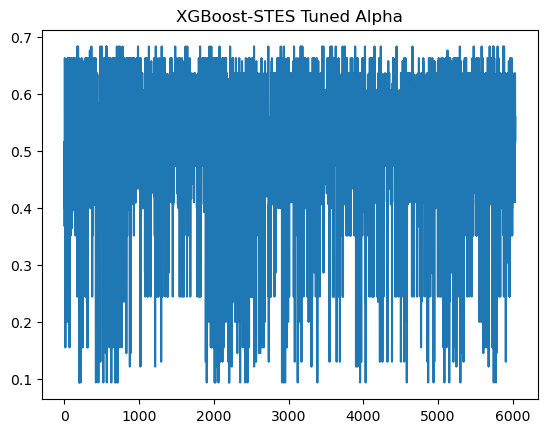

In [222]:
xgb_stes_spy_model_tuned_alpha = expit(xgb_stes_spy_model_tuned.predict(spy_feature_matrix))
plt.plot(xgb_stes_spy_model_tuned_alpha)
plt.title('XGBoost-STES Tuned Alpha');

##### XGBoost-STES (Tuned using Optuna) Forecast on SPY Realized Variance

In [293]:

import optuna

def xgb_stes_optuna_objective(trial):
    param = {
        "verbosity": 0,
        "num_boost_round": trial.suggest_int("num_boost_round", 1, 20),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-1, 10.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 10.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.6),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.6),
        "colsample_bynode": trial.suggest_float("colsample_bylevel", 0.3, 0.6),
    }

    xgb_stes_model = XGBoostExponentialSmoothing(**param)
    tscv = TimeSeriesSplit(n_splits=3)

    rmses = []
    for _, (train_idx, valid_idx) in enumerate(tscv.split(
        X_train,
        y_train,
    )):
        xgb_stes_model.fit(X_train.iloc[train_idx, :], y_train.iloc[train_idx])
        preds = xgb_stes_model.forecast_variance(X_train, burnin_size=10)
        score = xgb_stes_scoring_function(y_train.iloc[:valid_idx[-1]], preds[:valid_idx[-1]], valid_idx[0])
        rmses.append(score)
    return np.mean(rmses)



In [294]:
from optuna.samplers import TPESampler
sampler = TPESampler(seed = 0)

In [295]:
study_model = optuna.create_study(direction = 'maximize', sampler = sampler)
study_model.optimize(xgb_stes_optuna_objective, n_trials = 100) 

[I 2024-07-25 10:51:41,606] A new study created in memory with name: no-name-4ce208a7-292a-4b6a-bcd5-80d72876c9ad
[I 2024-07-25 10:51:42,029] Trial 0 finished with value: -60.08919158682274 and parameters: {'num_boost_round': 11, 'reg_lambda': 2.693883019285411, 'learning_rate': 0.6431172050131994, 'colsample_bytree': 0.463464954899069, 'colsample_bylevel': 0.4270964398016714}. Best is trial 0 with value: -60.08919158682274.
[I 2024-07-25 10:51:42,505] Trial 1 finished with value: -51.23637480166976 and parameters: {'num_boost_round': 13, 'reg_lambda': 0.7501954443620121, 'learning_rate': 4.734989304499476, 'colsample_bytree': 0.5890988281503088, 'colsample_bylevel': 0.4150324556477333}. Best is trial 1 with value: -51.23637480166976.
[I 2024-07-25 10:51:43,092] Trial 2 finished with value: -60.18369956481593 and parameters: {'num_boost_round': 16, 'reg_lambda': 1.1423254155608376, 'learning_rate': 0.5059803874660431, 'colsample_bytree': 0.5776789914877983, 'colsample_bylevel': 0.32131

In [286]:
trial = study_model.best_trial
xgb_stes_spy_best_params_optuna = trial.params
xgb_params_opt_tuned = xgb_params | xgb_stes_spy_best_params_optuna
xgb_params_opt_tuned
print('Best params from optuna: \n', pd.DataFrame.from_dict(xgb_params_opt_tuned, orient='index', columns=['Value']))

Best params from optuna: 
                        Value
max_depth           3.000000
learning_rate       6.823493
colsample_bytree    0.456554
colsample_bylevel   0.424399
colsample_bynode    0.800000
reg_lambda          0.193511
random_state       42.000000
num_boost_round    13.000000


In [316]:
xgb_stes_spy_model_opt_tuned = XGBoostExponentialSmoothing(**xgb_params_opt_tuned)
xgb_stes_spy_model_opt_tuned.fit(X_train, y_train)
xgb_stes_spy_model_opt_tuned_pred = xgb_stes_spy_model_opt_tuned.forecast_variance(
    spy_feature_matrix, burnin_size=10
)
is_xgb_stes_spy_opt_tuned_rmse = np.sqrt(np.mean((xgb_stes_spy_model_opt_tuned_pred[10:4000] - y_train.to_numpy()[10:])**2))
os_xgb_stes_spy_opt_tuned_rmse = np.sqrt(np.mean((xgb_stes_spy_model_opt_tuned_pred[4000:] - y_test.to_numpy())**2))


## Summary

In [134]:
_,        os_es_spy_rmse, _, _, _, is_es_spy_rmse, _ = fit_es_least_square(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000)
_,  os_stes_eae_spy_rmse, _, _, _, is_stes_eae_spy_rmse, _ = fit_stes_eae_least_square(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000)
_,  os_stes_ese_spy_rmse, _, _, _, is_stes_ese_spy_rmse, _ = fit_stes_ese_least_square(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000)
_, os_stes_aese_spy_rmse, _, _, _, is_stes_aese_spy_rmse, _ = fit_stes_aese_least_square(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000)

In [307]:
os_rmse = {
    'XGBoost-STES (Untuned)': os_xgb_stes_spy_untuned_rmse,
    'XGBoost-STES (Sklearn Tuned)': os_xgb_stes_spy_tuned_rmse,
    'XGBoost-STES (Optuna Tuned)': os_xgb_stes_spy_opt_tuned_rmse,
    
    'ES': os_es_spy_rmse,
    'STES-E&AE': os_stes_eae_spy_rmse,
    'STES-E&SE': os_stes_ese_spy_rmse,
    'STES-AE&SE': os_stes_aese_spy_rmse,
}

is_rmse = {
    'XGBoost-STES (Optuna Tuned)': is_xgb_stes_spy_opt_tuned_rmse,
    'XGBoost-STES (Sklearn Tuned)': is_xgb_stes_spy_tuned_rmse,
    'XGBoost-STES (Untuned)': is_xgb_stes_spy_untuned_rmse,
    'ES': is_es_spy_rmse,
    'STES-E&AE': is_stes_eae_spy_rmse,
    'STES-E&SE': is_stes_ese_spy_rmse,
    'STES-AE&SE': is_stes_aese_spy_rmse,
}
pd.concat([
    pd.DataFrame.from_dict(os_rmse, orient='index', columns=['OS']),
    pd.DataFrame.from_dict(is_rmse, orient='index', columns=['IS'])
], axis=1)

,OS,IS
XGBoost-STES (Untuned),4.419461,5.015513
XGBoost-STES (Sklearn Tuned),4.428388,5.201166
XGBoost-STES (Optuna Tuned),6.919553,6.933454
ES,4.639821,4.999671
STES-E&AE,4.520393,4.954623
STES-E&SE,4.498322,4.932206
STES-AE&SE,4.496488,4.961815


In [128]:
print(f"XGB STES SPY (Tuned) Error: {os_xgb_stes_spy_opt_tuned_rmse}")
print(f"XGB STES SPY (Untuned) Error: {os_xgb_stes_spy_untuned_rmse}")
print(f"ES SPY Error: {os_es_spy_rmse}")
print(f"STES E&AE SPY Error: {os_stes_eae_spy_rmse}")
print(f"STES E&SE SPY Error: {os_stes_ese_spy_rmse}")
print(f"STES AE&SE SPY Error: {os_stes_aese_spy_rmse}")

XGB STES SPY (Tuned) Error: 4.6832819149558915
XGB STES SPY (Untuned) Error: 4.570763478693617
ES SPY Error: 4.639822526766432
STES E&AE SPY Error: 4.520370404768722
STES E&SE SPY Error: 4.498308136804803
STES AE&SE SPY Error: 4.496473330081073
